# Aprendizaje residual

**Autor**: Arturo Sánchez Palacio

Basado en: https://github.com/lazyprogrammer

**Fecha de última revisión: 18/I/2020**

Como siempre comenzamos instalando los módulos que necesitamos e importándolos:

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Keras está optimizado para trabajar con enormes tamaños de datos por lo que en este caso trabajaremos con la base de datos __completa__:

In [2]:
df = pd.read_csv('./data/preprocessed_rating.csv')

Calculamos el número total de usuarios y películas:

In [3]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

Como es habitual en los procesos de Machine Learning dividimos en entrenamiento y test. En este caso fijamos el tamaño de entrenamiento al 80%:

In [4]:
df = shuffle(df)
umbral = int(0.8*len(df))
df_train = df.iloc[:umbral]
df_test = df.iloc[umbral:]

Inicializamos las variables habituales:

In [5]:
K = 10 # dimension latente
mu = df_train.rating.mean() #media global
iteraciones = 15 
reg = 0. # coeficiente de regularización

Ya hemos fijado las bases para construir el modelo. Importamos los tipos de capas que vamos a usar:

In [6]:
from keras.layers import Input, Embedding, Flatten

Using TensorFlow backend.


Empezamos creando las capas de entrada:

In [7]:
u = Input(shape=(1,)) # escalar del usuario
m = Input(shape=(1,)) # escalar de la película

Realizamos el embedding con la regularización del vector de usuario y de película en las matrices:

In [8]:
u_embedding = Embedding(N, K)(u) # dimensión: (N, 1, K)
m_embedding = Embedding(M, K)(m) # dimensión: (N, 1, K)

__Nota.__ Aquí es donde empieza a modificarse respecto al anterior.

En la rama principal se realiza la factorización de la matriz tal y como vimos en el notebook `keras_factorization`:

In [9]:
from keras.layers import Dot, Add
u_bias = Embedding(N, 1)(u) # dimensión: (N, 1, 1)
m_bias = Embedding(M, 1)(m) # dimensión: (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # dimensión: (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # dimensión: (N, 1)

En la "rama residual" construimos el modelo del notebook `neural_network`:

In [10]:
from keras.layers import Concatenate, Activation, Dropout, Dense
u_embedding = Flatten()(u_embedding) # dimensión: (N, K)
m_embedding = Flatten()(m_embedding) # dimensión: (N, K)
y = Concatenate()([u_embedding, m_embedding]) # dimensión: (N, 2K)
y = Dense(400)(y) # Capa densa con 400 neuronas
y = Activation('relu')(y)
y = Dropout(0.5)(y) # Dropout (reduce el input)
y = Dense(1)(y) # Aseguramos que la salida sea un número (la predicción del error)

Simplemente combinamos los dos modelos y con esto habríamos terminado de diseñar la arquitectura de la red:

In [11]:
x = Add()([x, y])

Una vez planteada la arquitectura del modelo el procedimiento es análogo al de los Notebooks anteriores. Instanciamos el modelo:

In [12]:
from keras.models import Model
model = Model(inputs=[u, m], outputs=x)

Lo compilamos:

In [13]:
from keras.optimizers import SGD
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

Este es el modelo construido:

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
____________________________________________________________________________________________

Nuestro modelo ya está listo para ser entrenado:

In [15]:
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values], #variables de entrada
  y=df_train.rating.values - mu, #etiquetas a predecir
  epochs=iteraciones,
  batch_size=128, #tamaño del batch
  validation_data=([df_test.userId.values, df_test.movie_idx.values],  df_test.rating.values - mu) #datos de validacion
)

/Users/arturosanchezpalacio/Entornos virtuales/recommendation_system_course/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000210 samples, validate on 4000053 samples
Epoch 1/15
16000210/16000210 [==============================] - 782s 49us/step - loss: 0.7686 - mse: 0.7686 - val_loss: 0.7302 - val_mse: 0.7302
Epoch 2/15
16000210/16000210 [==============================] - 786s 49us/step - loss: 0.7117 - mse: 0.7117 - val_loss: 0.7062 - val_mse: 0.7062
Epoch 3/15
16000210/16000210 [==============================] - 788s 49us/step - loss: 0.6753 - mse: 0.6753 - val_loss: 0.6715 - val_mse: 0.6715
Epoch 4/15
16000210/16000210 [==============================] - 790s 49us/step - loss: 0.6395 - mse: 0.6395 - val_loss: 0.6474 - val_mse: 0.6474
Epoch 5/15
16000210/16000210 [==============================] - 788s 49us/step - loss: 0.6140 - mse: 0.6140 - val_loss: 0.6466 - val_mse: 0.6466
Epoch 6/15
16000210/16000210 [==============================] - 803s 50us/step - loss: 0.5976 - mse: 0.5976 - val_loss: 0.6476 - val_mse: 0.6476
Epoch 7/15
16000210/16000210 [==============================] - 804s 50us/s

El objeto r almacena en su historia las pérdidas a lo largo del entrenamiento y podemos tanto observarlas como representarlas:

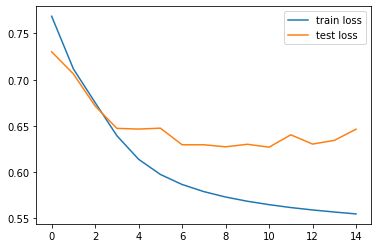

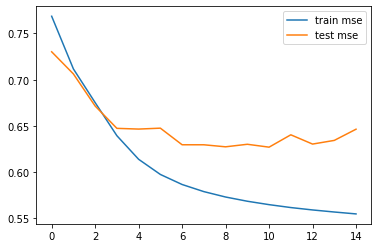

In [21]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

## Conclusión

Parece que los resultados no mejoran mucho. Esto parece sugerirnos que en este caso concreto no hay una relación no lineal que aprender a partir de los residuos. Esto no es generalizable a los problemas de recomendación si no tan solo a los datos con los que estamos trabajando en este caso.